# EDA 

## path and imports 

In [6]:
import os, numpy as np, pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
os.chdir("..")   # go up one folder
print(os.getcwd())  # confirm it's now the project root

# Paths to raw npz data
TILE_TRAIN = "data/raw/npz_all/npz/tile/xla/train"
TILE_VALID = "data/raw/npz_all/npz/tile/xla/valid"
TILE_TEST  = "data/raw/npz_all/npz/tile/xla/test"

LAYOUT_XLA_RANDOM_TRAIN   = "data/raw/npz_all/npz/layout/xla/random/train"
LAYOUT_XLA_DEFAULT_TRAIN  = "data/raw/npz_all/npz/layout/xla/default/train"
LAYOUT_NLP_RANDOM_TRAIN   = "data/raw/npz_all/npz/layout/nlp/random/train"
LAYOUT_NLP_DEFAULT_TRAIN  = "data/raw/npz_all/npz/layout/nlp/default/train"

PB_LAYOUT_ROOT = "data/raw/pb/pb/layout"


/Users/tanpinyee/Documents/GitHub/predict-ai-model-runtime


### sanity check 


In [7]:
for p in [TILE_TRAIN, LAYOUT_XLA_RANDOM_TRAIN]:
    ok = os.path.isdir(p)
    print(f"{p} ->", "OK" if ok else "MISSING", 
          ("files:", len(os.listdir(p))) if ok else "")
    if ok: print("sample:", os.listdir(p)[:3])


data/raw/npz_all/npz/tile/xla/train -> OK ('files:', 5709)
sample: ['transformer.4x4.bf16_-1964d3f4fc587b76.npz', 'mnasnet_a1_batch_128_-2c00b4aa48eb6515.npz', 'resnet_v2_200_batch_64_-56670efcbaa402de.npz']
data/raw/npz_all/npz/layout/xla/random/train -> OK ('files:', 69)
sample: ['brax_es.npz', 'transformer.4x4.fp32.performance.npz', 'resnet50.8x8.fp32.npz']


In [8]:
sample_tile = np.load(os.path.join(TILE_TRAIN, os.listdir(TILE_TRAIN)[0]), allow_pickle=True)
print(sample_tile.files)
for k in sample_tile.files:
    print(k, sample_tile[k].shape, sample_tile[k].dtype)


['node_feat', 'node_opcode', 'edge_index', 'config_feat', 'config_runtime', 'config_runtime_normalizers']
node_feat (34, 140) float32
node_opcode (34,) uint8
edge_index (33, 2) int64
config_feat (437, 24) float32
config_runtime (437,) int64
config_runtime_normalizers (437,) int64


In [9]:
rows = []
files = os.listdir(TILE_TRAIN)
for f in tqdm(files[:300]):  # start small; increase later
    d = np.load(os.path.join(TILE_TRAIN, f), allow_pickle=True)

    n_nodes   = d["node_feat"].shape[0]
    n_edges   = d["edge_index"].shape[0]
    n_cfgs    = d["config_feat"].shape[0]
    rt        = d["config_runtime"].astype(np.float64)
    rnorm     = d["config_runtime_normalizers"].astype(np.float64)
    ratio     = rt / rnorm
    best_idx  = int(np.argmin(ratio))
    best_ratio= float(ratio[best_idx])
    best_rt   = float(rt[best_idx])

    rows.append({
        "file": f,
        "num_nodes": n_nodes,
        "num_edges": n_edges,
        "num_configs": n_cfgs,
        "runtime_min_ns": best_rt,
        "ratio_min": best_ratio,
    })

tile_df = pd.DataFrame(rows)
tile_df.head()


100%|██████████| 300/300 [00:00<00:00, 1054.14it/s]


,file,num_nodes,num_edges,num_configs,runtime_min_ns,ratio_min
0,transformer.4x4.bf16_-1964d3f4fc587b76.npz,34,33,437,183575.0,0.992716
1,mnasnet_a1_batch_128_-2c00b4aa48eb6515.npz,38,37,403,132762.0,0.982055
2,resnet_v2_200_batch_64_-56670efcbaa402de.npz,2,1,414,49760.0,0.935444
3,retinanet.4x4.fp32_5045ab5a5565be70.npz,14,13,166,64071.0,0.958186
4,efficientnet_b7_eval_batch_1_-5ac1b66665d93955...,59,61,728,205101.0,0.988515


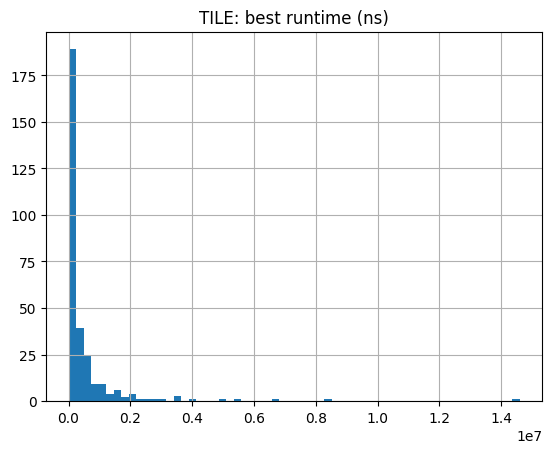

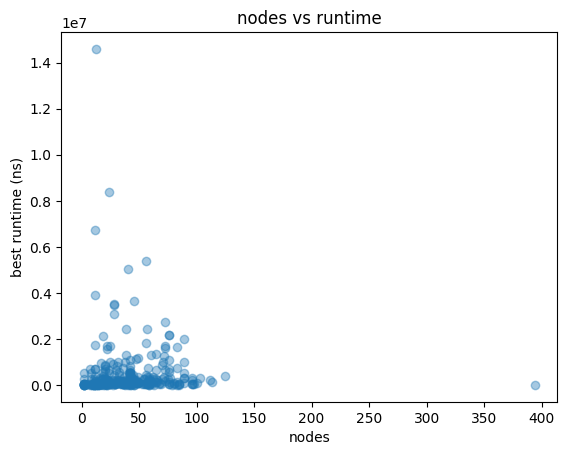

In [10]:
tile_df["runtime_min_ns"].hist(bins=60); plt.title("TILE: best runtime (ns)"); plt.show()
plt.scatter(tile_df["num_nodes"], tile_df["runtime_min_ns"], alpha=0.4)
plt.xlabel("nodes"); plt.ylabel("best runtime (ns)"); plt.title("nodes vs runtime"); plt.show()


In [11]:
os.makedirs("data/processed", exist_ok=True)
tile_df.to_csv("data/processed/tile_train_summary.csv", index=False)
print("saved -> data/processed/tile_train_summary.csv")


saved -> data/processed/tile_train_summary.csv


In [12]:
sample_layout = np.load(os.path.join(LAYOUT_XLA_RANDOM_TRAIN, os.listdir(LAYOUT_XLA_RANDOM_TRAIN)[0]), allow_pickle=True)
print(sample_layout.files)
for k in sample_layout.files:
    print(k, sample_layout[k].shape, sample_layout[k].dtype)


['edge_index', 'node_feat', 'node_opcode', 'node_config_feat', 'node_config_ids', 'node_splits', 'config_runtime']
edge_index (7209, 2) int64
node_feat (4185, 140) float32
node_opcode (4185,) uint8
node_config_feat (100040, 81, 18) float32
node_config_ids (81,) int64
node_splits (1, 2) int64
config_runtime (100040,) int64


In [13]:
rows = []
files = os.listdir(LAYOUT_XLA_RANDOM_TRAIN)
for f in tqdm(files[:300]):
    d = np.load(os.path.join(LAYOUT_XLA_RANDOM_TRAIN, f), allow_pickle=True)

    n_nodes = d["node_feat"].shape[0]
    n_edges = d["edge_index"].shape[0]
    nc      = d["node_config_ids"].shape[0]
    cfgs    = d["node_config_feat"].shape[0]  # number of runs/configs
    rt      = d["config_runtime"].astype(np.float64)

    rows.append({
        "file": f,
        "num_nodes": n_nodes,
        "num_edges": n_edges,
        "num_configurable_nodes": nc,
        "num_runs": cfgs,
        "runtime_min_ns": float(rt.min()),
        "runtime_mean_ns": float(rt.mean()),
        "runtime_max_ns": float(rt.max()),
        "runtime_spread_ns": float(rt.max() - rt.min()),
    })

layout_df = pd.DataFrame(rows)
layout_df.head()


100%|██████████| 69/69 [00:13<00:00,  4.95it/s]


,file,num_nodes,num_edges,num_configurable_nodes,num_runs,runtime_min_ns,runtime_mean_ns,runtime_max_ns,runtime_spread_ns
0,brax_es.npz,4185,7209,81,100040,4729001.0,1.004016e+07,19567302.0,14838301.0
1,transformer.4x4.fp32.performance.npz,26234,48094,1777,15704,53452292.0,7.415945e+07,98656219.0,45203927.0
2,resnet50.8x8.fp32.npz,5345,8775,166,10664,114509310.0,1.906543e+08,268757330.0,154248020.0
3,bert_pretraining.8x16.fp16.npz,21335,37236,1142,19128,46152420.0,5.607547e+07,67327314.0,21174894.0
4,transformer.2x2.fp32.npz,7324,12087,414,22992,50591575.0,8.265765e+07,114871545.0,64279970.0


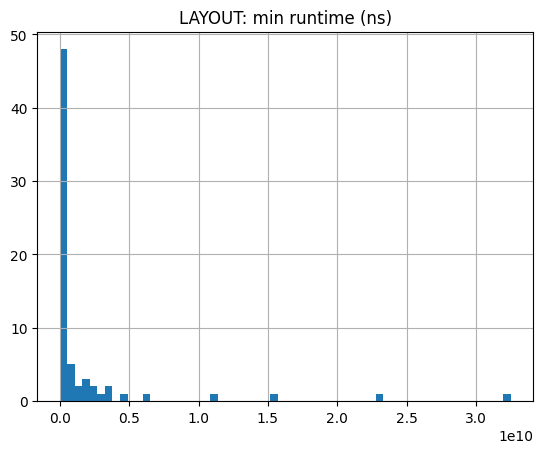

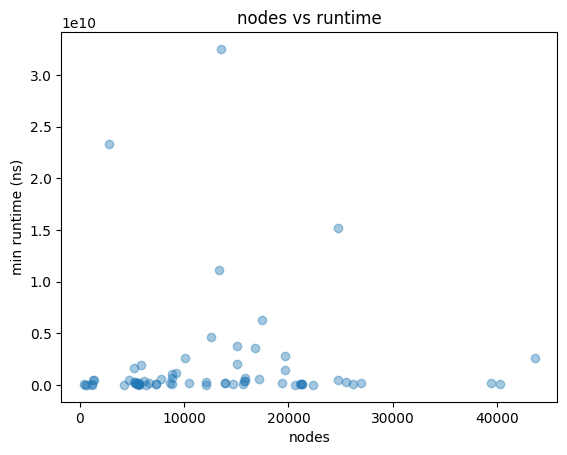

In [14]:
layout_df["runtime_min_ns"].hist(bins=60); plt.title("LAYOUT: min runtime (ns)"); plt.show()
plt.scatter(layout_df["num_nodes"], layout_df["runtime_min_ns"], alpha=0.4)
plt.xlabel("nodes"); plt.ylabel("min runtime (ns)"); plt.title("nodes vs runtime"); plt.show()


In [15]:
layout_df.to_csv("data/processed/layout_xla_random_train_summary.csv", index=False)
print("saved -> data/processed/layout_xla_random_train_summary.csv")


saved -> data/processed/layout_xla_random_train_summary.csv
